In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

import numpy as np
import pandas as pd

In [0]:
dest = Path('/content/model')
dest.mkdir(parents=True, exist_ok=True)

modeldest = Path('/content/model/models')
modeldest.mkdir(parents=True, exist_ok=True)

In [0]:
bs = 128

In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_47.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_119.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_136.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_60.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_259.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
data = ImageDataBunch.from_name_re(
    path_img, 
    fnames, 
    pat, 
    valid_pct=0.2,
    ds_tfms=get_transforms(), 
    size=224, 
    bs=bs
    ).normalize(imagenet_stats)

data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
British_Shorthair,scottish_terrier,Ragdoll,yorkshire_terrier,havanese
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_bulldog,english_setter,german_shorthaired,Bombay,pug
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

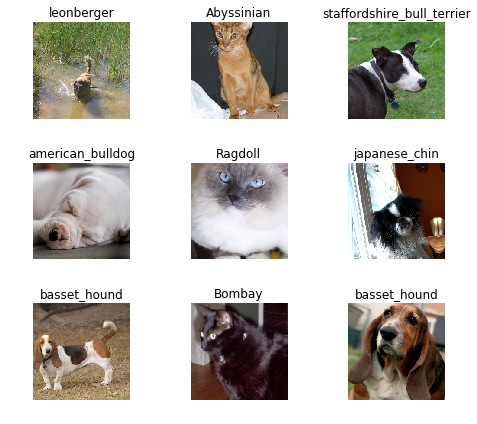

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training Model

In [13]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 117161860.67it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


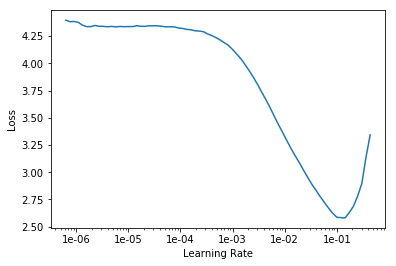

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
torch.cuda.is_available()

True

In [16]:
learn.fit_one_cycle(4, max_lr=slice(5e-03,1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,1.162963,3.442722,0.426928,01:42
1,2.393938,2.470009,0.311908,01:42
2,1.861250,0.738218,0.177267,01:41
3,1.159730,0.453530,0.123139,01:41


In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

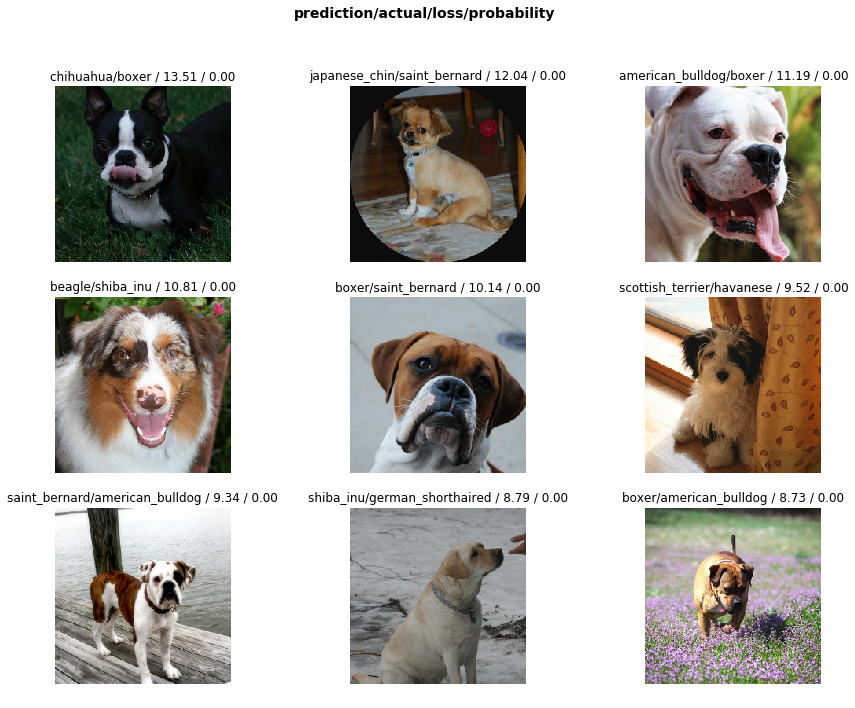

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

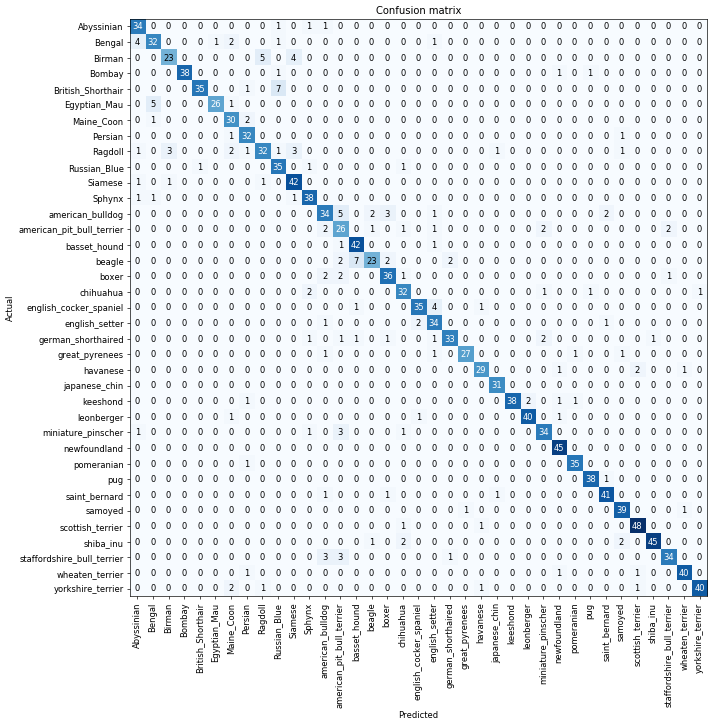

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 7),
 ('beagle', 'basset_hound', 7),
 ('Birman', 'Ragdoll', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 5),
 ('Bengal', 'Abyssinian', 4),
 ('Birman', 'Siamese', 4),
 ('english_cocker_spaniel', 'english_setter', 4),
 ('Ragdoll', 'Birman', 3),
 ('Ragdoll', 'Siamese', 3),
 ('american_bulldog', 'boxer', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Maine_Coon', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Ragdoll', 'Maine_Coon', 2),
 ('american_bulldog', 'beagle', 2),
 ('american_bulldog', 'saint_bernard', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('beagle', 'american_pit_bull_terrier', 2),
 ('beagle', 'boxer', 2),
 ('beagle', 'germa

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


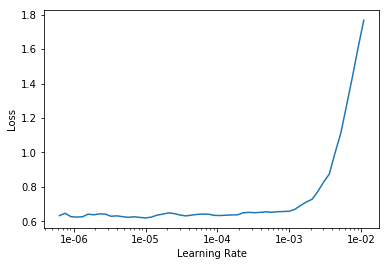

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.647752,0.453015,0.124493,01:44
1,0.646225,0.501356,0.125169,01:45
2,0.605399,0.411170,0.115020,01:45
3,0.585677,0.422488,0.110284,01:45
4,0.558629,0.397331,0.113667,01:45
5,0.546450,0.391523,0.108254,01:45
6,0.525002,0.391713,0.106901,01:46
7,0.507015,0.390604,0.109608,01:46


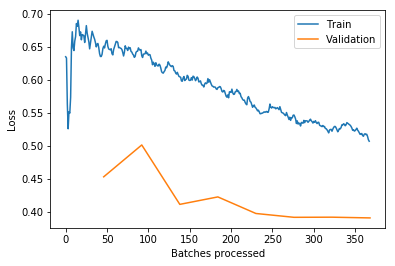

In [24]:
learn.recorder.plot_losses()

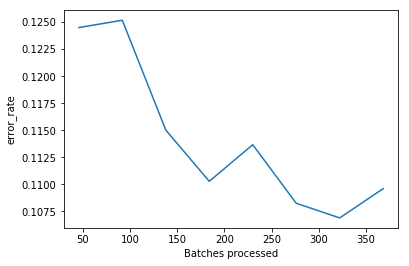

In [25]:
learn.recorder.plot_metrics()

In [0]:
learn.export(dest/'export.pkl')
learn.save(modeldest/'stage-2')

## Upload Trained Model to Azure Storage Account Blob

In [27]:
!pip install azure-storage-blob

     |████████████████████████████████| 92kB 7.5MB/s 
     |████████████████████████████████| 51kB 21.4MB/s 
     |████████████████████████████████| 2.3MB 21.5MB/s 
     |████████████████████████████████| 102kB 26.5MB/s 


In [28]:
!ls /content/model/*

/content/model/export.pkl

/content/model/models:
stage-2.pth


In [29]:
import shutil,os
from datetime import datetime
from azure.storage.blob import BlockBlobService, PublicAccess

STORAGE_ACCOUNT = '<YOUR STORAGE ACCOUNT>'
STORAGE_KEY = '<YOUR STORAGE ACCOUNT KEY>'
container_name = datetime.now().strftime('%Y%m%d%H%M')

shutil.make_archive('/content/trained', 'zip', root_dir='/content/model')

block_blob_service = BlockBlobService(
    account_name=STORAGE_ACCOUNT, account_key=STORAGE_KEY)

block_blob_service.create_container(container_name)

block_blob_service.set_container_acl(
    container_name, public_access=PublicAccess.Blob)

block_blob_service.create_blob_from_path(
    container_name, 'trained.zip', os.path.join('/content','trained.zip'))